## Classification

In [204]:
from sklearn.linear_model import LogisticRegression

X = df_hrv_scaled['HRV']
y = df_hrv_scaled['At work']

log_reg = LogiscticRegression()
log_reg.fit()

KeyError: 'At work'

In [ ]:
import seaborn as sns
from matplotlib import dates
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from sklearn.preprocessing import StandardScaler
import tabulate
warnings.filterwarnings('ignore')
# sns.set(font_scale=5.5)
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)}, font_scale=1.5)
df_hrv = pd.read_csv("../data/original/HeartRateVariabilitySDNN.csv")

def parse_date(x):
    return pd.datetime.strptime(x[:-6],'%Y-%m-%d %H:%M:%S')

series = pd.read_csv('../data/original/HeartRateVariabilitySDNN.csv', header=0, index_col=5, parse_dates=[5], squeeze=True, date_parser=parse_date)

df_new = pd.DataFrame()
df_new['value'] = series['value'].resample('H').mean().interpolate()
df_new['creationDate'] = pd.to_datetime(df_new.index)
df_new = df_new.reset_index(drop=True)

df_new['t+1'] = df_new['value'].shift(periods=1)
df_new['t+24'] = df_new['value'].shift(periods=24)
df_new.head()

df_hrv_filtered = df_new

##### 

scaler = StandardScaler()
hrv_merged = pd.DataFrame()

def at_work(row):
#     print(row['creationDate'].hour)
    derp = row['creationDate'].hour
    hour = row['creationDate'].hour
    weekday = row['creationDate'].isoweekday()
    
    if((hour >= 9 and hour <17) and weekday < 6):
        # print(pd.to_datetime(row['creationDate']), (weekday))
        return 1
    return 0
    
# winter is from 1st of November to 1st of April
def is_winter(row):
    month = pd.to_datetime(row['creationDate'], format='%d/%m').month
    
    if(month >= 10 or month < 4):
        return 1
    return 0

def is_higher_than_mean(row):
    mean = 41.25
    if row.value > mean:
        return 1
    return 0

def get_hour_of_day(row):
    hour = pd.to_datetime(row['creationDate']).hour
    return hour

def get_day_of_week(row):
    weekday = pd.to_datetime(row['creationDate']).isoweekday()
    return weekday

def get_time_of_day(row):
    hour = pd.to_datetime(row['creationDate']).hour
    
    if((hour >= 6 and hour <12)):
        return 1
    return 0
    
    
hrv_merged['date'] = df_hrv_filtered['creationDate']
hrv_merged['HRV (SDNN)'] = df_hrv_filtered['value']

work_hours = []
winter_time = []
above_mean = []
hour_of_day = []
day_of_week = []
time_of_day = [] # is morning or afternoon



for (index, row) in df_hrv_filtered.iterrows():

        
    work_hours.append(at_work(row))
#     winter_time.append(is_winter(row))
    above_mean.append(is_higher_than_mean(row))
    hour_of_day.append(get_hour_of_day(row))
    day_of_week.append(get_day_of_week(row))
    time_of_day.append(get_time_of_day(row))
    if (row['value'] > 150):
        df_hrv_filtered.drop(index, inplace=True)
    
hrv_merged['Is at Work (binary)'] = work_hours
hrv_merged['Is Above Mean Value'] = above_mean
hrv_merged['Hour of Day'] = hour_of_day
hrv_merged['Day of Week'] = day_of_week
hrv_merged['Is Morning'] = time_of_day
# hrv_merged['new date'] = hrv_merged['date'].astype(np.int64).values.reshape(-1,1)
hrv_merged['t+1'] = df_hrv_filtered['t+1']

hrv_merged.to_csv('../data/hrv_shaped.csv')

# sns.heatmap(hrv_merged.corr(),
#             vmin=-1,
#             cmap='coolwarm',
#             annot=True);



In [206]:
hrv_merged.head(75)

,date,HRV (SDNN),Is at Work (binary),Is Above Mean Value,Hour of Day,Day of Week,Is Morning,t+1
0,2018-01-16 09:00:00,38.754700,1,0,9,2,1,NaN
1,2018-01-16 10:00:00,36.479380,1,0,10,2,1,38.754700
2,2018-01-16 11:00:00,34.204060,1,0,11,2,1,36.479380
3,2018-01-16 12:00:00,31.928740,1,0,12,2,0,34.204060
4,2018-01-16 13:00:00,29.653420,1,0,13,2,0,31.928740
...,...,...,...,...,...,...,...,...
70,2018-01-19 07:00:00,51.628108,0,1,7,5,1,49.513217
71,2018-01-19 08:00:00,53.743000,0,1,8,5,1,51.628108
72,2018-01-19 09:00:00,53.181989,1,1,9,5,1,53.743000
73,2018-01-19 10:00:00,52.620978,1,1,10,5,1,53.181989


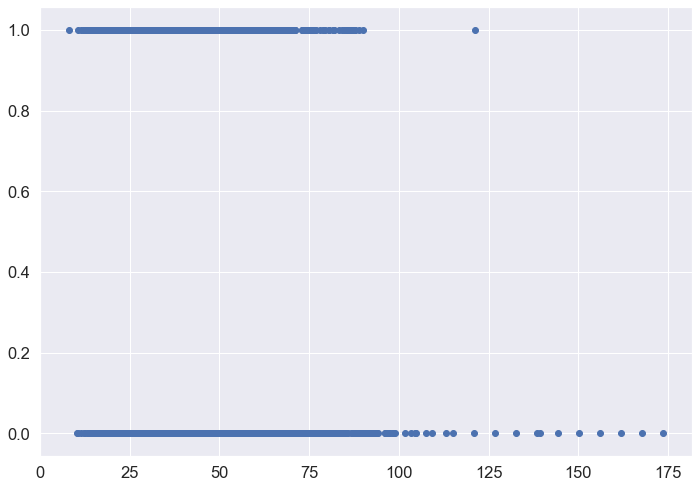

In [148]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

X = hrv_merged['HRV (SDNN)'].values.reshape(-1,1)
y = hrv_merged['Is at Work (binary)']

plt.scatter(X,y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [161]:
import numpy as np

log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

print('coef: {0}'.format(log_reg.coef_))
print('intercept: {0}'.format(log_reg.intercept_))

y_pred = log_reg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {0}'.format(log_reg.score(X_test, y_test)))

y_proba = log_reg.predict_proba(X_test)

confusion_matrix(y_test, y_pred)

# print((2332-683)/2332+683)



coef: [[-0.00030238]]
intercept: [-1.13345761]
Accuracy of logistic regression classifier on test set: 0.7734660033167496


array([[2332,    0],
       [ 683,    0]])

[0 0]


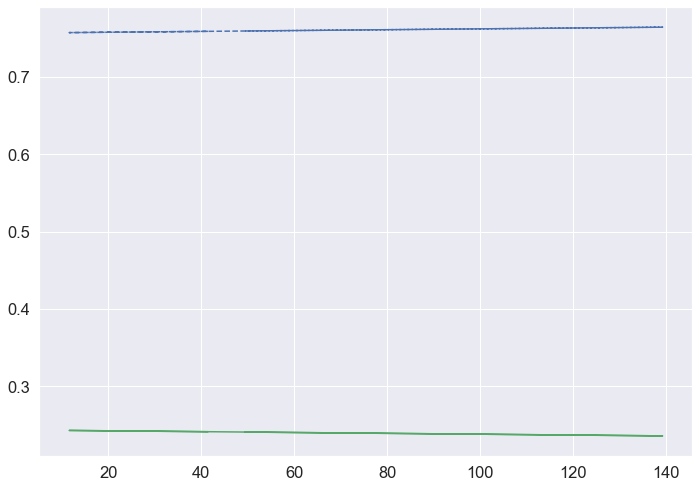

In [167]:
plt.plot(X_test, y_proba[:,1], "g-", label="Is At Work")
plt.plot(X_test, y_proba[:,0], "b--", label="Is Not At Work")

print(log_reg.predict([[43], [125]]))

## Cross validation (baseline, log regression, neural network)

In [202]:
from sklearn import model_selection
import tensorflow as tf
from tensorflow import keras

K=5
outerCV = model_selection.KFold(n_splits=K)
innerCV = model_selection.KFold(n_splits=K)

n_alphas = 10
alphas = np.logspace(0, 1, n_alphas)
# alphas = range (1, 11, n_alphas)

i=0
for outer_train_index, outer_test_index in outerCV.split(X, y):
    print('Crossvalidation fold: {0}/{1}'.format(i+1,K))
    i+=1

    log_reg_inner_error = []
    log_reg_min_error = 1
    nn_inner_error = []
    min_nn_error = 1
    
    # Outer folds
    X_train_outer, y_train_outer = X[outer_train_index,:], y[outer_train_index]
    X_test_outer, y_test_outer = X[outer_test_index,:], y[outer_test_index]
    
    # baseline (log regression)
    log_reg = LogisticRegression()
    log_reg.fit(X_train_outer,y_train_outer)
        
    print('Baseline error: {0}'.format(1-log_reg.score(X_test_outer, y_test_outer)))
    
    # Inner folds
    for inner_train_index, inner_test_index in outerCV.split(X_train_outer):
        X_train_inner, y_train_inner = X[inner_train_index,:], y[inner_train_index]
        X_test_inner, y_test_inner = X[inner_test_index,:], y[inner_test_index]
        
        # baseline (log regression)
        log_reg = LogisticRegression()
        log_reg.fit(X_train_inner,y_train_inner)
    
        # log regression (shifting lambdas)
        for alpha in alphas:
            log_reg_regularized = LogisticRegression(C=alpha)
            log_reg_regularized.fit(X_train_inner,y_train_inner)
            log_reg_inner_error.append(1-log_reg_regularized.score(X_test_inner, y_test_inner))
#             print('Regulated error of logistic regression: {0}'.format(1-log_reg_regularized.score(X_test_inner, y_test_inner)))
         
        for hidden_layer_number in range(1,11):    
            model = keras.models.Sequential([
                keras.layers.Dense(hidden_layer_number, activation="relu", input_shape=X_train_inner.shape[1:]),
                keras.layers.Dense(1)
            ])

            model.compile(loss="mean_squared_error", optimizer="sgd")
            history = model.fit(np.asarray(X_train_inner), np.asarray(y_train_inner), verbose=0)
            mse_test = model.evaluate(np.asarray(X_test_inner), np.asarray(y_test_inner), verbose=0)
            nn_inner_error.append({
                'error': mse_test,
                'h': hidden_layer_number
            })
            
        for item in nn_inner_error:
            if (item['error'] < min_nn_error):
                min_nn_error = item['error']
            if (item['error'] == min_nn_error):
                min_nn_h = item['h']
        
        print('Neural network error:', min_nn_error)
        
        
#### NOTE: NEED TO TRAIN IN THE OUTER MODEL WITH THE BEST PARAMETER OF THE INNER MODEL ####
        
    



Crossvalidation fold: 1/5
Baseline error: 0.23880597014925375
Neural network error: 0.18350074515611575
Neural network error: 0.18003405385324808
Neural network error: 0.18003405385324808
Neural network error: 0.18003405385324808
Neural network error: 0.18003405385324808
Crossvalidation fold: 2/5
Baseline error: 0.23814262023217247
Neural network error: 0.1835007907739326
Neural network error: 0.180041396344825
Neural network error: 0.180041396344825
Neural network error: 0.180041396344825
Neural network error: 0.180041396344825
Crossvalidation fold: 3/5
Baseline error: 0.23681592039800992
Neural network error: 0.18349988513918064
Neural network error: 0.18003496245340525
Neural network error: 0.18003496245340525
Neural network error: 0.18003496245340525
Neural network error: 0.18003496245340525
Crossvalidation fold: 4/5
Baseline error: 0.23880597014925375
Neural network error: 0.18349936233824166
Neural network error: 0.18003443679826375
Neural network error: 0.18003443679826375
Neura